In [1]:
import sys
print(sys.version)

3.8.16 (default, Dec  7 2022, 01:12:13) 
[GCC 7.5.0]


In [2]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [3]:
import tensorflow as tf
from tensorflow import keras
from keras import layers, models, regularizers
from keras.layers import Flatten, add, Dense, Dropout 
from keras.callbacks import ModelCheckpoint, EarlyStopping


print("TensorFlow version:", tf.__version__)
tf.keras.backend.set_floatx('float64')

TensorFlow version: 2.9.2


In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
import os
import csv
import random

import cv2
import imutils
import glob
# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [5]:
#Określenie ścieżek do plików
test_zip = '/content/drive/MyDrive/Sieci/Baza_zdjec_przeplatane_2/Test.zip'
test_csv = 'test.csv'

train_zip = '/content/drive/MyDrive/Sieci/Baza_zdjec_przeplatane_2/Train.zip'
train_csv = 'train.csv'

folder = '/content/drive/MyDrive/Sieci/Baza_zdjec_przeplatane_2/'
slesh = '/'
png = '.png'

In [6]:
#!unzip '/content/drive/MyDrive/Sieci/Baza_zdjec_przeplatane_2/Train.zip' -d '/content/train/'
#!unzip '/content/drive/MyDrive/Sieci/Baza_zdjec_przeplatane_2/Test.zip' -d '/content/test/'

Archive:  /content/drive/MyDrive/Sieci/Baza_zdjec_przeplatane_2/Train.zip
replace /content/train/22679.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: Archive:  /content/drive/MyDrive/Sieci/Baza_zdjec_przeplatane_2/Test.zip
replace /content/test/2513.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [13]:
def release_list(a):
    
    del a[:]
    del a

In [14]:
#Wczytanie etykiet do treninegu 

with open(folder+train_csv,"r") as csvfile:
    lines = csvfile.readlines()
csvfile.close()

new = []

for i in lines:
    new.append(i.split(" "))

    
value_train = []
for i in new[0]:
    value_train.append(int(i))    
    
print(len(value_train))

22680


In [15]:
#Wczytanie etykiet do testowania

with open(folder+test_csv,"r") as csvfile:
    lines = csvfile.readlines()
csvfile.close()

new = []

for i in lines:
    new.append(i.split(" "))

    
value_test = []
for i in new[0]:
    value_test.append(int(i))    
    
print(len(value_test))

2520


In [10]:
#Wczytanie zdjęć treningowych (90% całego zbioru)
images_train = []
size = len(value_train)

for i in range(size):
    im = Image.open('/content/train/'+str(i)+'.png')
    arr_im = np.array(im) 
    arr_im = arr_im / 255.0
    images_train.append(arr_im) 
print(len(images_train))

22680


In [11]:
#Wczytanie zdjęć testowych (10% całego zbioru)
images_test = []
size = len(value_test)

for i in range(size):
    im = Image.open('/content/test/'+str(i)+'.png')
    arr_im = np.array(im) 
    arr_im = arr_im / 255.0
    images_test.append(arr_im) 
print(len(images_test))

2520


In [16]:
x_train = np.array(images_train)
x_test = np.array(images_test)

y_train = np.array(value_train)
y_test = np.array(value_test)

0


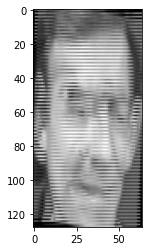

In [17]:
a = 19000
plt.imshow(x_train[a],cmap = 'gray')
print(y_train[a])

In [18]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 64, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.BatchNormalization())

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))


model.add(layers.BatchNormalization())

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='relu'))


In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 62, 32)       320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 31, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 29, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 14, 32)       0         
 2D)                                                             
                                                                 
 batch_normalization (BatchN  (None, 30, 14, 32)       128       
 ormalization)                                                   
                                                        

In [20]:
model.compile(optimizer='adam',
              loss='mse',
              metrics=['accuracy','mse'])

#Funcka umożliwia zatrzymanie się uczenia 
#gdy wartość strat przstanie maleć
EarlyStop = EarlyStopping(monitor='val_loss',  
                          verbose=1, 
                          patience=10)


ModelCheck = ModelCheckpoint(filepath='/content/drive/MyDrive/Sieci/Przeplatane_forefox.h5',
                             monitor='val_loss',
                             save_best_only=True)

history = model.fit(x=x_train, 
                    y=y_train, 
                    epochs=100,
                    batch_size=128,
                    validation_split=0.1,
                    callbacks = [EarlyStop, ModelCheck]
                   )

Epoch 1/100
160/160 [==============================] - 36s 195ms/step - loss: 3.0564 - accuracy: 0.8119 - mse: 0.1838 - val_loss: 0.2620 - val_accuracy: 0.9938 - val_mse: 0.1206
Epoch 2/100
160/160 [==============================] - 31s 194ms/step - loss: 0.0821 - accuracy: 0.9663 - mse: 0.0352 - val_loss: 0.0497 - val_accuracy: 1.0000 - val_mse: 0.0288
Epoch 3/100
160/160 [==============================] - 31s 195ms/step - loss: 0.0317 - accuracy: 0.9878 - mse: 0.0169 - val_loss: 0.0496 - val_accuracy: 0.9850 - val_mse: 0.0379
Epoch 4/100
160/160 [==============================] - 31s 193ms/step - loss: 0.0195 - accuracy: 0.9945 - mse: 0.0102 - val_loss: 0.0230 - val_accuracy: 0.9877 - val_mse: 0.0119
Epoch 5/100
160/160 [==============================] - 31s 194ms/step - loss: 0.0158 - accuracy: 0.9972 - mse: 0.0075 - val_loss: 0.0186 - val_accuracy: 0.9828 - val_mse: 0.0118
Epoch 6/100
160/160 [==============================] - 31s 194ms/step - loss: 0.0116 - accuracy: 0.9981 - mse:

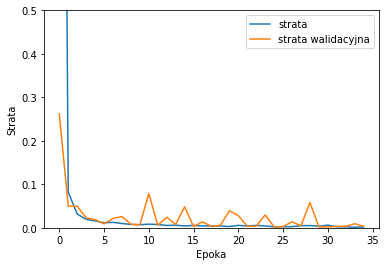

In [21]:
plt.plot(history.history['loss'], label='strata')
plt.plot(history.history['val_loss'], label = 'strata walidacyjna')
plt.xlabel('Epoka')
plt.ylabel('Strata')
plt.ylim([0.0, 0.5])
plt.legend(loc='upper right')

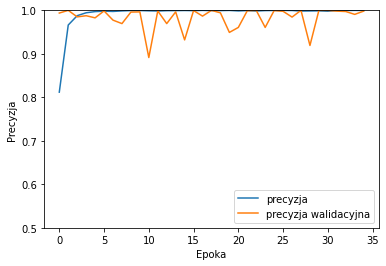

In [22]:
plt.plot(history.history['accuracy'], label='precyzja')
plt.plot(history.history['val_accuracy'], label = 'precyzja walidacyjna')
plt.xlabel('Epoka')
plt.ylabel('Precyzja')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

In [23]:
model.evaluate(x_test,  y_test, verbose=2)

79/79 - 1s - loss: 0.0223 - accuracy: 0.9722 - mse: 0.0209 - 1s/epoch - 16ms/step


[0.022335898849290922, 0.9722222222222222, 0.020934954015023138]

In [24]:
best_model = tf.keras.models.load_model('/content/drive/MyDrive/Sieci/Przeplatane_forefox.h5')

In [25]:
best_model.evaluate(x_test,  y_test, verbose=2)

79/79 - 1s - loss: 0.1057 - accuracy: 0.8722 - mse: 0.1041 - 1s/epoch - 16ms/step


[0.10574003217665777, 0.8722222222222222, 0.10413515069386103]

In [26]:
predict_x = best_model.predict(x_test) 

predictions = (predict_x > 0.5).astype("int32")

79/79 [==============================] - 1s 11ms/step


In [27]:
names = [['Tn','Nn'],['Np', 'Tp']]
names = np.reshape(names,(2,2))
print(names)

conf = tf.math.confusion_matrix(y_test,predictions)

print(conf)

[['Tn' 'Nn']
 ['Np' 'Tp']]
tf.Tensor(
[[1260    0]
 [ 322  938]], shape=(2, 2), dtype=int32)
